In [1]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from armadata import ARMAVolumeDataset
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from arch import arch_model
from scipy.stats import gennorm
import statsmodels.api as sm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
train_dataset = ARMAVolumeDataset(dt.datetime(2022, 9, 30), dt.datetime(2023, 5, 8))
val_dataset = ARMAVolumeDataset(dt.datetime(2023, 5, 9), dt.datetime(2023, 7, 19))
test_dataset = ARMAVolumeDataset(dt.datetime(2023, 7, 20), dt.datetime(2023, 9, 30))

In [3]:
train_data = train_dataset.process_data()
val_data = val_dataset.process_data()
test_data = test_dataset.process_data()

[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv
[INFO] Saved processed dataset to: /Users/Samantha/Downloads/PyTorch-Code-ARMA-ARMA_LSTM-main/processed_arma_volume_dataset.csv


In [4]:
train_series = pd.Series(train_data['log_diff_volume'].values)
val_series = pd.Series(val_data['log_diff_volume'].values)
test_series = pd.Series(test_data['log_diff_volume'].values)

In [5]:
train_diff = train_series.values
val_diff = val_series.values
test_diff = test_series.values

In [6]:
#STATIONARY, AUTOCORR TESTS
adf_result = adfuller(train_diff)
print("\n[ADF Test - train_diff]")
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")


[ADF Test - train_diff]
ADF Statistic: -25.271467
p-value: 0.000000


In [7]:
lb_test = acorr_ljungbox(train_diff, lags=[20], return_df=True)
p_value = lb_test['lb_pvalue'].iloc[0]
print(f"Ljung-Box p-value at lag 20: {p_value:.6f}")

Ljung-Box p-value at lag 20: 0.000000


## Added to see a good range for grid searching

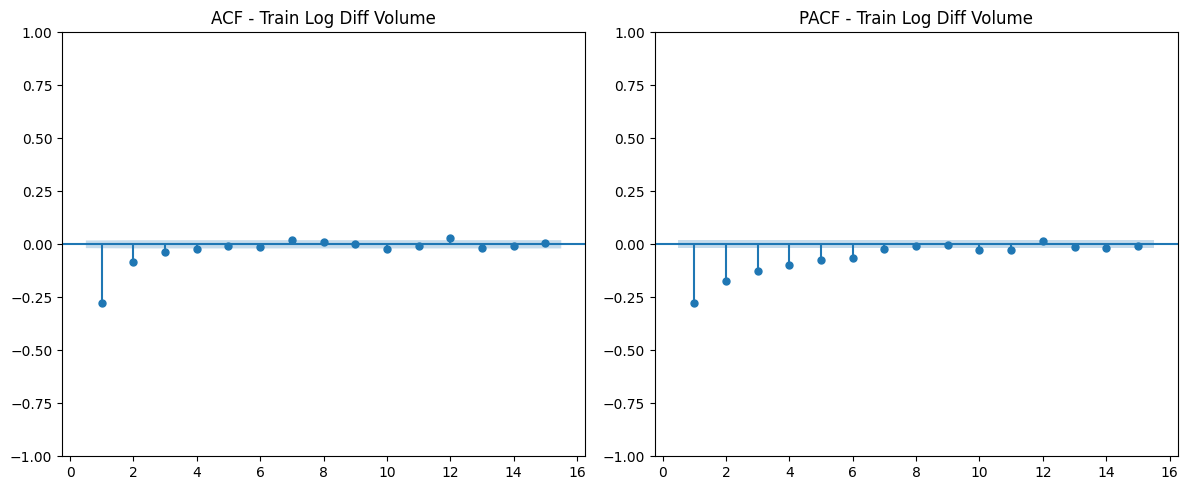

In [8]:
#ACF AND PACF GRAPHS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(train_series, lags=15, zero=False, ax=plt.gca())
plt.title("ACF - Train Log Diff Volume")
plt.subplot(1, 2, 2)
plot_pacf(train_series, lags=15, zero=False, ax=plt.gca())
plt.title("PACF - Train Log Diff Volume")
plt.tight_layout()
plt.show()

## Previously tried p & q until 10 but worried about overfitting since it started giving ARMA(7,...) as best model

In [9]:
#CHOOSE THE BEST ARIMAX MODEL
orders = {}
for q in range(1, 3):
    orders[f"MA({q})"] = (0, 0, q)

for p in range(1, 3):
    orders[f"AR({p})"] = (p, 0, 0)

for p in range(1, 3):
    for q in range(1, 3):
        orders[f"ARMA({p},{q})"] = (p, 0, q)

for p in range(1, 3):
    for d in range(1, 3):
        for q in range(1, 3):
            orders[f"ARIMA({p},{d},{q})"] = (p, d, q)


In [10]:
results = []
best_rmse = np.inf

for name, order in orders.items():
    
    model = ARIMA(train_series, order=order)
    model_fit = model.fit()
    
    val_series_aligned = pd.Series(val_series.values, index=pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(val_series)))
    updated_model = model_fit.append(val_series_aligned)
    
    forecast_series = updated_model.predict(start=len(train_series), end=len(train_series) + len(val_series) - 1, dynamic=False)
    forecast = np.nan_to_num(forecast_series.values, nan=0.0)
    
    rmse = np.sqrt(mean_squared_error(val_diff, forecast))
    results.append({'model': name, 'order': order, 'RMSE': rmse})


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

In [11]:
orders

{'MA(1)': (0, 0, 1),
 'MA(2)': (0, 0, 2),
 'AR(1)': (1, 0, 0),
 'AR(2)': (2, 0, 0),
 'ARMA(1,1)': (1, 0, 1),
 'ARMA(1,2)': (1, 0, 2),
 'ARMA(2,1)': (2, 0, 1),
 'ARMA(2,2)': (2, 0, 2),
 'ARIMA(1,1,1)': (1, 1, 1),
 'ARIMA(1,1,2)': (1, 1, 2),
 'ARIMA(1,2,1)': (1, 2, 1),
 'ARIMA(1,2,2)': (1, 2, 2),
 'ARIMA(2,1,1)': (2, 1, 1),
 'ARIMA(2,1,2)': (2, 1, 2),
 'ARIMA(2,2,1)': (2, 2, 1),
 'ARIMA(2,2,2)': (2, 2, 2)}

In [12]:
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\n[MODEL COMPARISON SUMMARY]")
print(results_df.to_string(index=False))


[MODEL COMPARISON SUMMARY]
       model     order         RMSE
   ARMA(2,1) (2, 0, 1) 4.904227e-01
   ARMA(1,2) (1, 0, 2) 4.904348e-01
ARIMA(2,1,2) (2, 1, 2) 4.905184e-01
   ARMA(2,2) (2, 0, 2) 4.906159e-01
   ARMA(1,1) (1, 0, 1) 4.906396e-01
ARIMA(1,1,2) (1, 1, 2) 4.906614e-01
       MA(2) (0, 0, 2) 4.915789e-01
       MA(1) (0, 0, 1) 4.939477e-01
       AR(2) (2, 0, 0) 5.007903e-01
ARIMA(2,1,1) (2, 1, 1) 5.008115e-01
       AR(1) (1, 0, 0) 5.075855e-01
ARIMA(1,1,1) (1, 1, 1) 5.076031e-01
ARIMA(1,2,2) (1, 2, 2) 5.088422e-01
ARIMA(2,2,1) (2, 2, 1) 6.367639e-01
ARIMA(1,2,1) (1, 2, 1) 6.969463e-01
ARIMA(2,2,2) (2, 2, 2) 2.791049e+07


In [13]:
#TO CHECK USING VIF LATER
sing_exog_vars = ['log_return', 'relative_open', 'relative_high', 'relative_low', 'relative_close']

In [14]:
#CHECK VIF OF EXOG
vif_data = train_data[sing_exog_vars].dropna()
X_vif = sm.add_constant(vif_data)
vif_results = pd.DataFrame()
vif_results["Variable"] = X_vif.columns
vif_results["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\n[VIF CHECK]")
print(vif_results.to_string(index=False))


[VIF CHECK]
      Variable      VIF
         const 0.000000
    log_return 2.339801
 relative_open 2.048584
 relative_high      inf
  relative_low      inf
relative_close 1.888704


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [15]:
#TO TEST EXOG COMBINATIONS AFTER VIF
exog_vars = [
    'log_return', 'relative_open', 'relative_close',
    ['log_return', 'relative_open'],
    ['log_return', 'relative_close'],
    ['relative_open', 'relative_close'],
    ['log_return', 'relative_open', 'relative_close']
]

In [16]:
results_exog = []
best_rmse_exog = np.inf
best_order = results_df.iloc[0]['order'] 
best_train_residuals = None
best_val_residuals = None
best_var = None
best_val_forecast = None

for var in exog_vars:
    cols = var if isinstance(var, list) else [var]
    name = "+".join(cols)

    exog_train = train_data[cols].iloc[:len(train_series)].values
    exog_val = val_data[cols].iloc[:len(val_series)].values
    
    model = ARIMA(train_series, order=best_order, exog=exog_train)
    model_fit = model.fit()

    train_resid = model_fit.resid
    val_indices = pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(val_series))
    
    exog_val_df = pd.DataFrame(exog_val, index=val_indices)
    val_series_clean = pd.Series(val_series.values, index=val_indices)
    updated_model = model_fit.append(val_series_clean, exog=exog_val_df)
    forecast_series = updated_model.predict(start=val_indices[0], end=val_indices[-1], exog=exog_val_df)
    forecast = np.nan_to_num(forecast_series.values, nan=0.0)

    rmse = np.sqrt(mean_squared_error(val_diff, forecast))
    results_exog.append({'exog_set': name, 'RMSE': rmse})

    if rmse < best_rmse_exog:
        best_rmse_exog = rmse
        best_var = name
        best_val_residuals = val_diff - forecast
        best_train_residuals = train_resid
        best_val_forecast = forecast 


## Slight improvement from ARMA(2,1) RMSE: 4.904227e-01

In [17]:
exog_results_df = pd.DataFrame(results_exog).sort_values('RMSE').drop_duplicates(subset='RMSE')
best_row = exog_results_df.iloc[0]
best_exog_cols = best_row['exog_set'].split('+')

print("\n[EXOGENOUS SELECTION SUMMARY]")
print(exog_results_df.to_string(index=False))


[EXOGENOUS SELECTION SUMMARY]
                               exog_set     RMSE
log_return+relative_open+relative_close 0.489787
              log_return+relative_close 0.489793
           relative_open+relative_close 0.490025
                             log_return 0.490131
                          relative_open 0.490154
               log_return+relative_open 0.490210
                         relative_close 0.490427


In [18]:
train_residuals = pd.Series(best_train_residuals)
val_residuals = pd.Series(best_val_residuals)
val_forecast = best_val_forecast.flatten() 
train_val_residuals = pd.concat([train_residuals, val_residuals], ignore_index=True)

In [19]:
#CHECK FOR GARCH EFFECTS
arch_lm_result = het_arch(train_residuals)
print("\n[ARCH-LM Test - train_residuals]")
print(f"ARCH-LM Statistic: {arch_lm_result[0]:.6f}")
print(f"p-value: {arch_lm_result[1]:.6f}")


[ARCH-LM Test - train_residuals]
ARCH-LM Statistic: 834.531344
p-value: 0.000000


## Prevously tried p & q from 1-10 but gave GARCH(10,10) as the best, and thought it might be too much. Checked with literature and found its usually GARCH/EGARCH (1,1)

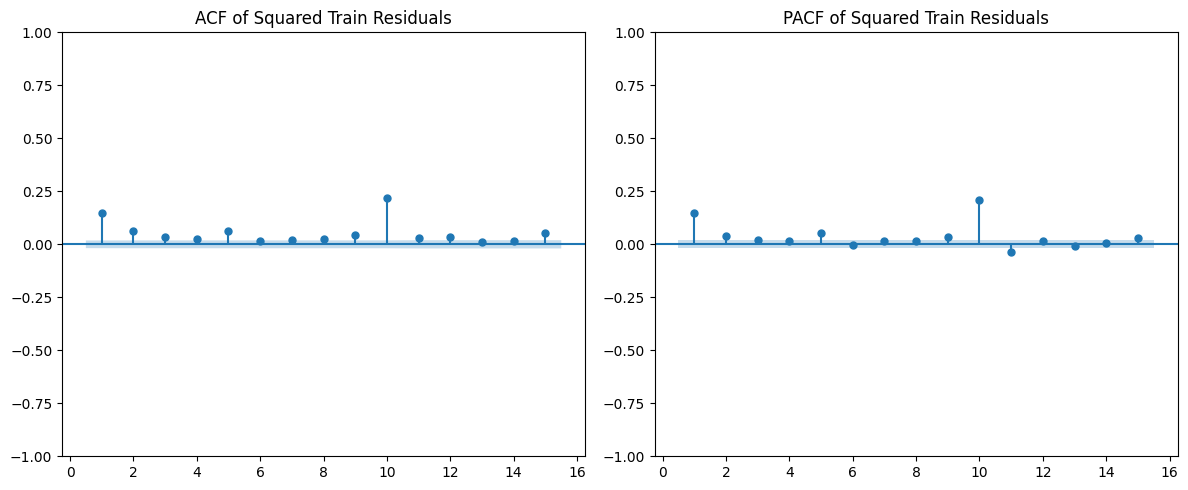

In [20]:
#CHECK CANDIDATE LAGS FOR GARCH
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(np.square(train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("ACF of Squared Train Residuals")
plt.subplot(1, 2, 2)
plot_pacf(np.square(train_residuals), lags=15, zero=False, ax=plt.gca())
plt.title("PACF of Squared Train Residuals")
plt.tight_layout()
plt.show()

In [21]:
#FIND THE BEST GARCH MODEL
arch_results = []
best_rmse_vol = np.inf
best_params_vol = None

## Getting base prediction + vol prediction, referenced last year's thesis and kept the replications before averaging epsilon

In [22]:
vol_types, lags_p, lags_q, dists = ['GARCH', 'EGARCH'], [1], [1, 2], ['normal', 't', 'ged']
vol_results = []
H_val = len(val_residuals)

In [23]:
n_sims = 1000 

for v, p, q, d in itertools.product(vol_types, lags_p, lags_q, dists):
    try:
        model_train = arch_model(train_residuals, vol=v, p=p, q=q, dist=d, mean="Zero").fit(disp='off')
        model_fixed = arch_model(train_val_residuals, vol=v, p=p, q=q, dist=d, mean="Zero").fix(model_train.params)
        val_volatility = model_fixed.conditional_volatility[val_residuals.index]

        rs = np.random.RandomState(1)
        all_epsilons = [] 

        #REFERENCED https://github.com/paulomercado/ThesisCodes/blob/main/GARCH.py
        for _ in range(n_sims):
            if d == 'normal':
                epsilon = rs.normal(loc=0, scale=1, size=H_val)
            elif d == 't':
                epsilon = rs.standard_t(df=model_train.params['nu'], size=H_val)
            elif d == 'ged':
                epsilon = gennorm.rvs(beta=model_train.params['nu'], size=H_val, random_state=rs)
            all_epsilons.append(epsilon)
        
        avg_epsilon = np.mean(all_epsilons, axis=0)
        
        simulated_noise = val_volatility.values * avg_epsilon
        final_prediction = val_forecast + simulated_noise
        
        rmse = np.sqrt(mean_squared_error(val_diff, final_prediction))
        vol_results.append({'Model': f"{v}({p},{q})-{d}", 'Avg_RMSE': rmse})
        
    except Exception as e:
        print(f"Failed for {v}({p},{q})-{d}: {e}")
        continue
        
vol_summary = pd.DataFrame(vol_results).sort_values('Avg_RMSE')
print("\n[VOLATILITY SUMMARY]")
print(vol_summary.to_string(index=False))

best_row = vol_summary.iloc[0]

best_garch_params = {
    'vol': best_row['Model'].split('(')[0],
    'p': int(best_row['Model'].split('(')[1].split(',')[0]),
    'q': int(best_row['Model'].split(',')[1].split(')')[0]),
    'dist': best_row['Model'].split('-')[1],
    'rmse': best_row['Avg_RMSE']
}


[VOLATILITY SUMMARY]
             Model  Avg_RMSE
     EGARCH(1,1)-t  0.489437
     EGARCH(1,2)-t  0.489437
    GARCH(1,2)-ged  0.489644
    GARCH(1,1)-ged  0.489764
      GARCH(1,2)-t  0.489889
      GARCH(1,1)-t  0.489889
 GARCH(1,1)-normal  0.489907
 GARCH(1,2)-normal  0.489907
EGARCH(1,2)-normal  0.489920
EGARCH(1,1)-normal  0.489920
   EGARCH(1,2)-ged  0.490020
   EGARCH(1,1)-ged  0.490065


In [24]:
exog_train = train_data[best_exog_cols].iloc[:len(train_series)].values
exog_test  = test_data[best_exog_cols].iloc[:len(test_series)].values

arimax_fit = ARIMA(train_series, order=best_order, exog=exog_train).fit()

test_indices = pd.RangeIndex(start=len(train_series), stop=len(train_series) + len(test_series))
exog_test_df = pd.DataFrame(exog_test, index=test_indices)
test_series_clean = pd.Series(test_series.values, index=test_indices)

updated_arimax_test = arimax_fit.append(test_series_clean, exog=exog_test_df)
test_forecast = updated_arimax_test.predict(start=test_indices[0], end=test_indices[-1], exog=exog_test_df)

rmse_test = np.sqrt(np.mean((test_diff - test_forecast.values)**2))
print(f"ARMAX Test RMSE: {rmse_test:.6f}")

ARMAX Test RMSE: 0.407491


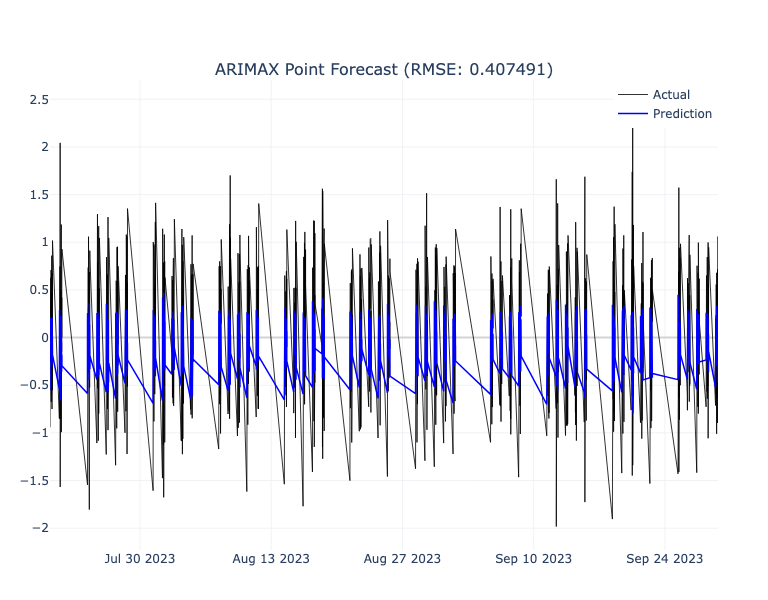

In [25]:
#PLOT RESULTS
fig = make_subplots(rows=1, cols=1, subplot_titles=[f"ARIMAX Point Forecast (RMSE: {rmse_test:.6f})"])
fig.add_trace(go.Scatter(x=test_data.index[-len(test_diff):], y=test_diff, name="Actual", line=dict(color='black', width=1), opacity=0.8), row=1, col=1)
fig.add_trace(go.Scatter(x=test_data.index[-len(test_diff):], y=test_forecast, name="Prediction", line=dict(color='blue', width=1.5)), row=1, col=1)
fig.update_layout(template="plotly_white", height=600, showlegend=True, legend=dict(orientation="v", yanchor="top", y=1, xanchor="right", x=1), margin=dict(l=50, r=50, t=80, b=50))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', tickformat='%b %d %Y')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f0f2f6', zeroline=True, zerolinecolor='lightgrey')
fig.show()


## Testing on the test set

In [26]:
test_residuals = pd.Series(test_diff - test_forecast.values.flatten())

train_val_test_residuals = pd.concat([train_residuals, val_residuals, test_residuals], ignore_index=True)
H_test = len(test_residuals)

test_residuals = train_val_test_residuals.tail(H_test) 

In [27]:
garch_conf = {k: v for k, v in best_garch_params.items() if k != 'rmse'}
model_train_final = arch_model(train_residuals, **garch_conf, mean="Zero").fit(disp="off", show_warning=False)
model_fixed_final = arch_model(train_val_test_residuals, **garch_conf, mean="Zero").fix(model_train_final.params)

test_volatility = model_fixed_final.conditional_volatility[test_residuals.index]

rs = np.random.RandomState(1)
d = best_garch_params['dist']
n_sims = 1000
all_epsilons = []

for _ in range(n_sims):
    if d == 'normal':
        eps = rs.normal(0, 1, H_test)
    elif d == 't':
        eps = rs.standard_t(df=model_train_final.params['nu'], size=H_test)
    elif d == 'ged':
        eps = gennorm.rvs(beta=model_train_final.params['nu'], size=H_test, random_state=rs)
    all_epsilons.append(eps)

avg_epsilon = np.mean(all_epsilons, axis=0)

simulated_test_noise = test_volatility.values * avg_epsilon
final_test_prediction = test_forecast.values.flatten() + simulated_test_noise

rmse_combined = np.sqrt(mean_squared_error(test_diff, final_test_prediction))

print(f"Test ARMAX RMSE: {rmse_test:.6f}")
print(f"Test ARMAX x GARCH ({d}) RMSE: {rmse_combined:.6f}")

Test ARMAX RMSE: 0.407491
Test ARMAX x GARCH (t) RMSE: 0.407587
